# Electron vs. Photon Classification

**Importing Necessary Libraries**

In [1]:
import numpy as np
import h5py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score


In [2]:
import matplotlib.pyplot as plt

In [3]:
torch.cuda.set_device(0)
torch.cuda.manual_seed_all(42)

Let's see some electrons

['X', 'y']
(249000, 32, 32, 2)
(249000,)


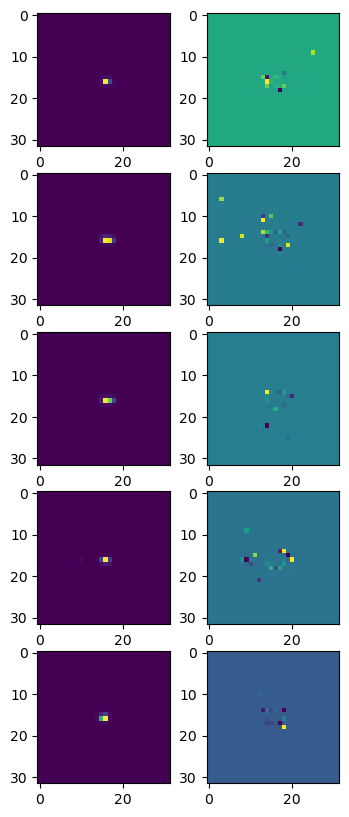

In [4]:
with h5py.File('/kaggle/input/electrons-and-photons/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
    print(list(f.keys()))
    
    dataset = f['X']
    pred = f['y']
    
    shape = dataset.shape
    p_shape = pred.shape
    
    print(shape)
    print(p_shape)
    
    electrons = dataset[10000:10005]
    
    plt.figure(figsize=(4, 10))
    
    for i in range(5):
        plt.subplot(5, 2, i*2 + 1)
        plt.imshow(electrons[i, :, :, 0])
        
        plt.subplot(5, 2, i*2 + 2)
        plt.imshow(electrons[i, :, :, 1])
        
    

Some Photons

['X', 'y']
(249000, 32, 32, 2)
(249000,)


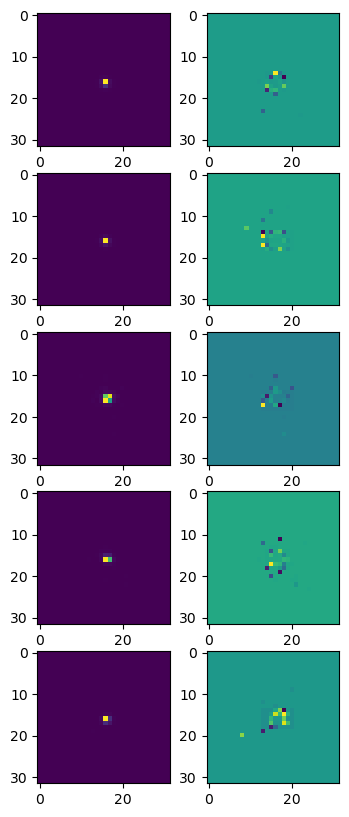

In [5]:
with h5py.File('/kaggle/input/electrons-and-photons/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
    print(list(f.keys()))
    
    dataset = f['X']
    pred = f['y']
    
    shape = dataset.shape
    p_shape = pred.shape
    
    print(shape)
    print(p_shape)
    
    electrons = dataset[10000:10005]
    
    plt.figure(figsize=(4, 10))
    
    for i in range(5):
        plt.subplot(5, 2, i*2 + 1)
        plt.imshow(electrons[i, :, :, 0])
        
        plt.subplot(5, 2, i*2 + 2)
        plt.imshow(electrons[i, :, :, 1])
        
    

We can use a Sparse CNN to classify electrons from photons

In [6]:
# Defining CNN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool1(nn.functional.relu(self.conv2(x)))
    
        x = nn.functional.relu(self.conv3(x))
        x = self.pool2(nn.functional.relu(self.conv4(x)))
        
        x = nn.functional.relu(self.conv5(x))
        x = self.pool3(nn.functional.relu(self.conv6(x)))
    
    
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return torch.sigmoid(x)

In [7]:
model = Net()

if torch.cuda.is_available():
    model = model.cuda()
    
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Defining the Data Loaders</br>
Let class 1 denote electrons and 0 denote photons</br>
80% data for training and 20% for validation

In [8]:
class HDF5Dataset(Dataset):
    def __init__(self, file_electrons, file_photons):
        self.file_path_e = file_electrons
        self.file_path_p = file_photons
        self.file_e = h5py.File(self.file_path_e, 'r')
        self.file_p = h5py.File(self.file_path_p, 'r')
        self.electrons = self.file_e['X']
        self.photons = self.file_p['X']
        self.data = np.concatenate((self.electrons, self.photons), axis=0)
        self.labels = np.concatenate((np.ones(self.electrons.shape[0]), np.zeros(self.photons.shape[0])), axis=0)
        self.labels = np.expand_dims(self.labels, axis=1)

    def __len__(self):
        return self.electrons.shape[0] + self.photons.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]), torch.from_numpy(np.asarray(self.labels[idx]))

    def close(self):
        self.file.close()


In [9]:
file_e = '/kaggle/input/electrons-and-photons/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
file_p = '/kaggle/input/electrons-and-photons/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
dataset = HDF5Dataset(file_e, file_p)

train_size = np.int32(0.8 * len(dataset))
val_size = len(dataset) - train_size

train, val = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train, batch_size=100, shuffle=True, num_workers=4)
val_loader = DataLoader(val, batch_size=100, shuffle=False, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Training**

In [10]:
epochs = 100
min_val_loss = np.inf

train_losses = []
val_losses = []
train_aucs = []
val_aucs = []
counter = 0

for e in range(epochs):
    train_loss = 0.0
    train_auc = 0.0
    i = 0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = model(inputs)
        labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        with torch.no_grad():
            train_auc += roc_auc_score(labels.numpy(), outputs.numpy())
        
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[Epoch %d, Batch %d] Loss: %.3f Accuracy: %.3f' %
                  (e + 1, i + 1, train_loss / 100, train_auc / 100))
            train_losses.append(train_loss / 100)
            train_aucs.append(train_auc / 100)
            train_loss = 0.0
            train_auc = 0.0
        
        i += 1
    
    with torch.no_grad():
        val_loss = 0.0
        val_auc = 0.0
        model.eval()
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            val_auc += roc_auc_score(labels.numpy(), outputs.numpy())
        
    print(f'Epoch {e+1} Val Loss: {val_loss / len(val_loader)} \t\t Val Accuracy: {val_auc / len(val_loader)}')
    
    val_losses.append(val_loss / len(val_loader))
    val_aucs.append(val_auc / len(val_loader))
     
    if min_val_loss > val_loss:
        print(f'Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
        min_val_loss = val_loss
        counter = 0 
            
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
        
    else:
        counter += 1
        if counter >= 10:
            print('Training Stopped : \t\t Loss did not decrease for 10 epochs.')
            break
        

[Epoch 1, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 1, Batch 200] Loss: 0.693 Accuracy: 0.490
[Epoch 1, Batch 300] Loss: 0.693 Accuracy: 0.501
[Epoch 1, Batch 400] Loss: 0.693 Accuracy: 0.493
[Epoch 1, Batch 500] Loss: 0.693 Accuracy: 0.499
[Epoch 1, Batch 600] Loss: 0.693 Accuracy: 0.503
[Epoch 1, Batch 700] Loss: 0.693 Accuracy: 0.489
[Epoch 1, Batch 800] Loss: 0.693 Accuracy: 0.505
[Epoch 1, Batch 900] Loss: 0.693 Accuracy: 0.494
[Epoch 1, Batch 1000] Loss: 0.693 Accuracy: 0.503
[Epoch 1, Batch 1100] Loss: 0.693 Accuracy: 0.498
[Epoch 1, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 1, Batch 1300] Loss: 0.693 Accuracy: 0.502
[Epoch 1, Batch 1400] Loss: 0.693 Accuracy: 0.511
[Epoch 1, Batch 1500] Loss: 0.693 Accuracy: 0.498
[Epoch 1, Batch 1600] Loss: 0.693 Accuracy: 0.494
[Epoch 1, Batch 1700] Loss: 0.693 Accuracy: 0.501
[Epoch 1, Batch 1800] Loss: 0.693 Accuracy: 0.492
[Epoch 1, Batch 1900] Loss: 0.693 Accuracy: 0.502
[Epoch 1, Batch 2000] Loss: 0.693 Accuracy: 0.507
[Epoch 1,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Val Loss: 0.6932127242945284 		 Val Accuracy: 0.5
Validation Loss Decreased(inf--->690.439873) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 2, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 2, Batch 2000] Loss: 0.693 Accuracy: 0.500
[Epoch 2,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Val Loss: 0.6931737243051989 		 Val Accuracy: 0.5
Validation Loss Decreased(690.439873--->690.401029) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 3, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 3, Batch 2000] Loss: 0.693 Accuracy: 0.500
[Epoch 3,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Val Loss: 0.6931516153506007 		 Val Accuracy: 0.5
Validation Loss Decreased(690.401029--->690.379009) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 4, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 4, Batch 2000] Loss: 0.693 Accuracy: 0.500
[Epoch 4,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Val Loss: 0.6932087249186144 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 5, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 5, Batch 2000] Loss: 0.693 Accuracy: 0.500
[Epoch 5,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Val Loss: 0.693206296508092 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 6, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 6, Batch 2000] Loss: 0.693 Accuracy: 0.500
[Epoch 6,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Val Loss: 0.6931459090436798 		 Val Accuracy: 0.5
Validation Loss Decreased(690.379009--->690.373325) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 7, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 7, Batch 2000] Loss: 0.693 Accuracy: 0.500
[Epoch 7,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Val Loss: 0.6931562595458395 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 8, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 8, Batch 2000] Loss: 0.693 Accuracy: 0.500
[Epoch 8,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Val Loss: 0.6931734593757185 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 9, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 9, Batch 2000] Loss: 0.693 Accuracy: 0.500
[Epoch 9,

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Val Loss: 0.6931931499137457 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 10, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 10, Batch 2000] Loss: 0.693 Accur

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Val Loss: 0.6931545125193386 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 11, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 11, Batch 2000] Loss: 0.693 Accur

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Val Loss: 0.6931580385888916 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 12, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 12, Batch 2000] Loss: 0.693 Accur

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Val Loss: 0.6931516205570305 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 13, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 13, Batch 2000] Loss: 0.693 Accur

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Val Loss: 0.6932782688772822 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 14, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 14, Batch 2000] Loss: 0.693 Accur

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Val Loss: 0.6931480774917755 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 15, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 15, Batch 2000] Loss: 0.693 Accur

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Val Loss: 0.6931661265083107 		 Val Accuracy: 0.5


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 16, Batch 100] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 200] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 300] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 400] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 500] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 600] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 700] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 800] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 900] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1000] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1100] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1200] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1300] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1400] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1500] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1600] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1700] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1800] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 1900] Loss: 0.693 Accuracy: 0.500
[Epoch 16, Batch 2000] Loss: 0.693 Accur

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Val Loss: 0.6931467907854831 		 Val Accuracy: 0.5
Training Stopped : 		 Loss did not decrease for 10 epochs.


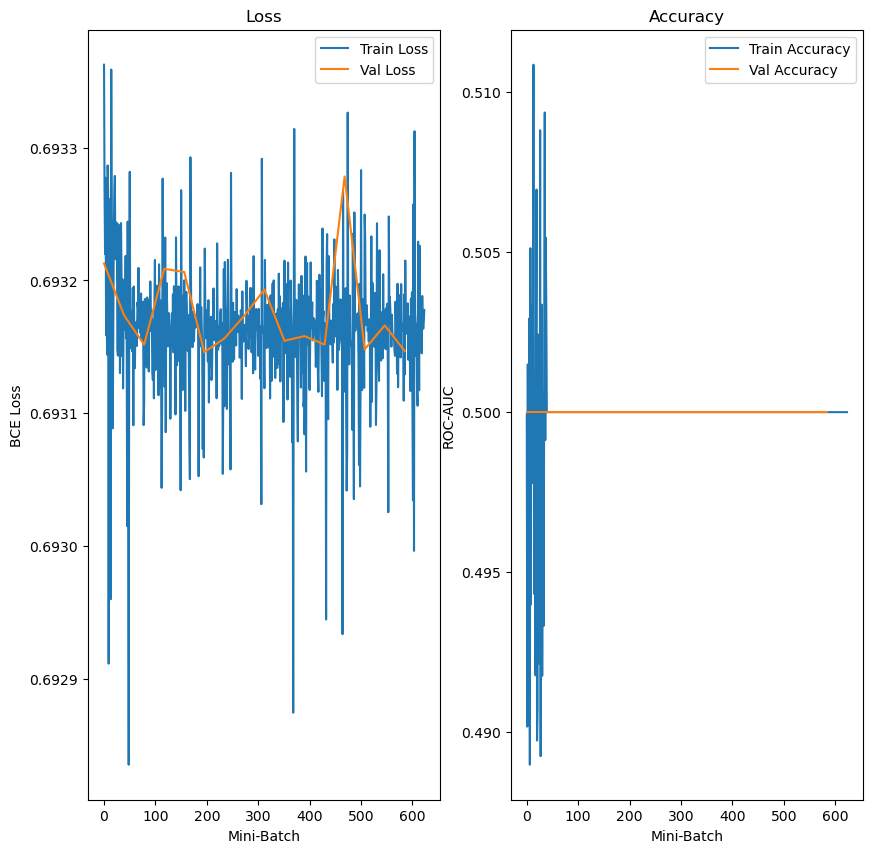

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.plot(np.arange(0, len(train_losses), int(len(train_losses)/len(val_losses))), val_losses, label='Val Loss')
plt.xlabel('Mini-Batch')
plt.ylabel('BCE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(train_aucs, label='Train Accuracy')
plt.plot(np.arange(0, len(train_aucs), int(len(train_aucs)/len(val_aucs))), val_aucs, label='Val Accuracy')
plt.xlabel('Mini-Batch')
plt.ylabel('ROC-AUC')
plt.legend()